In [1]:
import pyro
import pandas as pd
import numpy as np
import abc 
import matplotlib.pyplot as plt
import torch
import pyro.distributions as dist
import sqlite3
from procedural_generation.game_character_scene import draw_duel
conn = sqlite3.connect("./data/gamecharacters")

/home/mancunian92/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/mancunian92/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


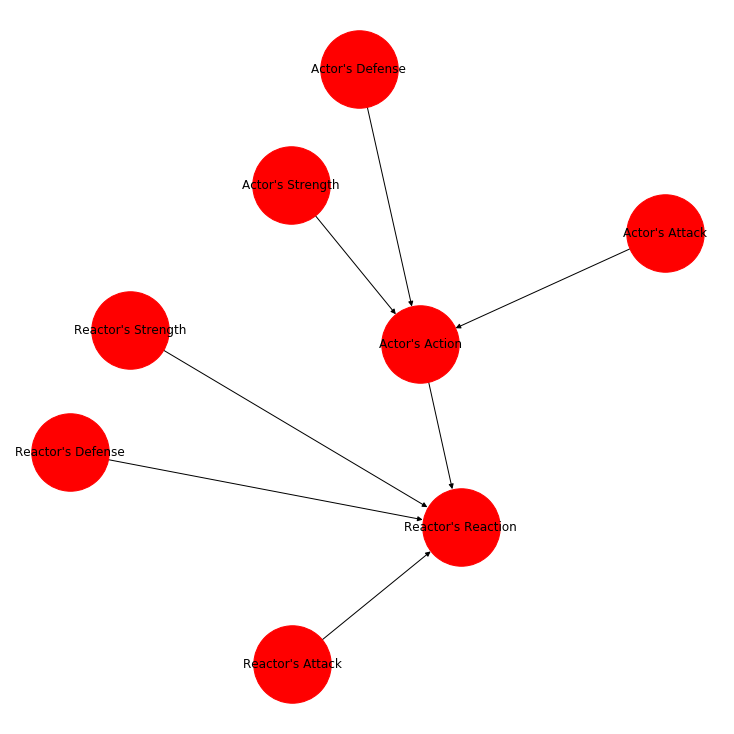

In [52]:
import networkx as nx
import matplotlib.pyplot as plt 

G = nx.MultiDiGraph()

G.add_edges_from([
    ("Actor's Strength", "Actor's Action"),
    ("Actor's Attack", "Actor's Action"),
    ("Actor's Defense", "Actor's Action"),
    ("Reactor's Strength", "Reactor's Reaction"),
    ("Reactor's Attack", "Reactor's Reaction"),
    ("Reactor's Defense", "Reactor's Reaction"),
    ("Actor's Action", "Reactor's Reaction")
])

plt.figure(figsize=(10,10))
nx.draw(G, pos=nx.spring_layout(G), with_labels = True, node_size=6000)

In [ ]:
'''
Probability of choosing an action[Attack, Taunt, Walking] depending on their strength, defense and attacking powers
000 -> [0.1, 0.3, 0.6],
001 -> [0.3, 0.5, 0.2],
010 -> [0.3, 0.4, 0.4],
011 -> [0.5,0.4,0.1],
100 -> [0.1, 0.2, 0.7],
101 -> [0.4,0.3,0.3],
110 -> [0.2, 0.4, 0.4],
111 -> [0.6, 0.3, 0.1]
'''

In [ ]:
'''
Probability of choosing a reaction [Dying, Hurt, Idle, Attack] depending on the reactor's
strength, defense and attack and attacker's reaction.

000A -> [0.5, 0.4, 0.05, 0.05]
000T ->[0.2, 0.6, 0.1, 0.1]
000W ->[0.001, 0.001, 0.997, 0.001]

001A -> [0.4, 0.3,0.1, 0.2]
001T -> [0.1, 0.5, 0.2, 0.2]
001W -> [0.001, 0.001, 0.99, 0.008]

010A -> [0.1, 0.3, 0.55, 0.05]
010T -> [0.1, 0.2, 0.65, 0.05]
010W -> [0.001, 0.001, 0.997, 0.001]

011A -> [0.3, 0.2, 0.3, 0.2]
011T -> [0.1, 0.3, 0.4, 0.2]
011W -> [0.001, 0.001, 0.99, 0.008]

100A -> [0.3, 0.3, 0.399, 0.001]
100T -> [0.2, 0.4, 0.399, 0.001]
100W -> [0.001, 0.001, 0.997, 0.001]

101A -> [0.3, 0.4, 0.1, 0.2]
101T -> [0.3, 0.3, 0.1, 0.3]
101W -> [0.001, 0.001, 0.99, 0.008]

110A -> [0.2, 0.3, 0.49, 0.01]
110T -> [0.1, 0.2, 0.59, 0.01]
110W -> [0.001, 0.001, 0.997, 0.001]

111A -> [0.2, 0.2, 0.4, 0.2]
111T -> [0.1, 0.1, 0.4, 0.4]
111W -> [0.001, 0.001, 0.99, 0.008]

'''

In [19]:
class GameCharacter(metaclass = abc.ABCMeta):
    values = {
        "actions": ["Attacking", "Taunt", "Walking"],
        "reactions": ["Dying", "Hurt", "Idle", "Attacking"],
        "strength": ["Low", "High"],
        "defense": ["Low", "High"],
        "attack": ["Low", "High"]
    }
    
    cpts = {
        "action": torch.tensor([[[[0.1, 0.3, 0.6], [0.3, 0.5, 0.2]], [[0.3, 0.4, 0.4], [0.5,0.4,0.1]]],
                                 [[[0.1, 0.2, 0.7], [0.4,0.3,0.3]], [[0.2, 0.4, 0.4], [0.6, 0.3, 0.1]]]]),
        
        "reaction": torch.tensor([[[[[0.5, 0.4, 0.05, 0.05], [0.2, 0.6, 0.1, 0.1], [0.001, 0.001, 0.997, 0.001]],
                        [[0.4, 0.3,0.1, 0.2], [0.1, 0.5, 0.2, 0.2], [0.001, 0.001, 0.99, 0.008]]],
                       [[[0.1, 0.3, 0.55, 0.05], [0.1, 0.2, 0.65, 0.05], [0.001, 0.001, 0.997, 0.001]],
                        [[0.3, 0.2, 0.3, 0.2],[0.1, 0.3, 0.4, 0.2],[0.001, 0.001, 0.99, 0.008]]]],
                      [[[[0.3, 0.3, 0.399, 0.001],[0.2, 0.4, 0.399, 0.001],[0.001, 0.001, 0.997, 0.001]],
                        [[0.3, 0.4, 0.1, 0.2],[0.3, 0.3, 0.1, 0.3],[0.001, 0.001, 0.99, 0.008]]],
                       [[[0.2, 0.3, 0.49, 0.01],[0.1, 0.2, 0.59, 0.01],[0.001, 0.001, 0.997, 0.001]],
                        [[0.2, 0.2, 0.4, 0.2],[0.1, 0.1, 0.4, 0.4],[0.001, 0.001, 0.99, 0.008]]]]]),
        "strength": torch.tensor([0.5,0.5]),
        "defense": torch.tensor([0.5, 0.5]),
        "attack": torch.tensor([0.5, 0.5])
    }
    
    infer_dict = {
        "attack": "_attack",
        "defense": "_defense",
        "strength": "_strength",
        "action": "_action",
        "reaction": "_reaction"
    }
    
     # Dictionary containing the connections sampled in the current model run
    existing_duels = dict()
    
    @abc.abstractmethod
    def observe(self):
        """
        Abstract method to make sure subclasses implement the observe function which allows the user 
        to set evidence pertaining to a class instance. 
        """
        pass
    
    @abc.abstractmethod
    def infer(self):
        """
        Abstract method to make sure subclasses implement the infer function which allows the user 
        infer a particular value for a class instance.
        """
        pass
    
    @staticmethod
    def evidence(conditions):
        """
        Forms a dictionary to be passed to pyro from a list of conditions formed by calling
        the observe function of each class object with the given observation. 
        
        :param list(dict) conditions: List of dictionaries, each dictionary having key as the 
            trace object related to the class object and its observed value.
        
        :return: Dictionary where the keys are trace objects and values are the observed values. 
        :rtype: dict(str, torch.tesnor)
        """
        
        cond_dict = {}
        for c in conditions:
            cond_dict[list(c.keys())[0]] = list(c.values())[0]
        
        return cond_dict
    
    @staticmethod
    def condition(model, evidence, infer, val, num_samples = 1000):
        """
        Uses pyro condition function with importance sampling to get the conditional probability 
        of a particular value for the random variable under inference. 
        
        :param func model: Probabilistic model defined with pyro sample methods.
        :param dict(str, torch.tensor) evidence: Dictionary with trace objects and their observed values.
        :param str infer: Trace object which needs to be inferred.
        :param int val: Value of the trace object for which the probabilities are required.
        :param int num_samples: Number of samples to run the inference alogrithm.
        
        :return: Probability of trace object being the value provided.
        :rtype: int
        """
        
        conditioned_model = pyro.condition(model, data = evidence)
        posterior = pyro.infer.Importance(conditioned_model, num_samples=num_samples).run()
        marginal = pyro.infer.EmpiricalMarginal(posterior, infer)
        samples = np.array([marginal().item() for _ in range(num_samples)])
        
        return sum([1 for s in samples if s.item() == val])/num_samples
    
    @staticmethod
    def intervention(model, evidence, infer, val, num_samples = 1000):
        """
        Uses pyro condition function with importance sampling to get the intervention probability 
        of a particular value for the random variable under inference.
        
        :param func model: Probabilistic model defined with pyro sample methods.
        :param dict(str, torch.tensor) evidence: Dictionary with trace objects and their observed values.
        :param str infer: Trace object which needs to be inferred.
        :param int val: Value of the trace object for which the probabilities are required.
        :param int num_samples: Number of samples to run the inference alogrithm.
        
        :return: Probability of trace object being the value provided.
        :rtype: int
        """
        
        intervention_model = pyro.do(model, data = evidence)
        posterior = pyro.infer.Importance(intervention_model, num_samples=num_samples).run()
        marginal = pyro.infer.EmpiricalMarginal(posterior, infer)
        samples = np.array([marginal().item() for _ in range(num_samples)])
        
        return sum([1 for s in samples if s.item() == val])/num_samples
    
    @staticmethod
    def draw_scene_with_inference(model, evidence, inferObj, num_samples = 1000, condition=True):
        # A scene is comprised of an action and reaction. We use the infer obj and get the max probability
        # among all categories for action and reaction.
        
        actions = GameCharacter.values['actions']
        reactions = GameCharacter.values['reactions']
        actions_prob = {}
        reactions_prob = {}
        
        for act in actions:
            idx = actions.index(act)
            if condition:
                actions_prob[act] = GameCharacter.condition(model, evidence, inferObj.infer("action"), idx)
            else:
                actions_prob[act] = GameCharacter.intervention(model, evidence, inferObj.infer("action"), idx)
        
        for rct in reactions:
            idx = reactions.index(rct)
            if condition:
                reactions_prob[rct] = GameCharacter.condition(model, evidence, inferObj.infer("reaction"), idx)
            else:
                reactions_prob[rct] = GameCharacter.intervention(model, evidence, inferObj.infer("reaction"), idx
                                                       )
        max_action = max(actions_prob, key=actions_prob.get)
        max_reaction = max(reactions_prob, key=reactions_prob.get)
        
        actor = {
            "name": inferObj.actor.character_name,
            "type": inferObj.actor.character_type,
            "action": max_action
        }
        
        reactor = {
            "name": inferObj.reactor.character_name,
            "type": inferObj.reactor.character_type,
            "reaction": max_reaction
        }
        
        return draw_duel(actor, reactor)
        
        

In [20]:
class Golem(GameCharacter):
    '''
    Can override the attack, defense and strength prior if needed for each character separately.
    '''
    types = ["golem1", "golem2", "golem3"]
    probs = torch.tensor([0.4, 0.3, 0.4])
    
    def __init__(self, iid):
        self.trace_var = "Golem_"+ str(iid)
        self.character_name = "Golem"
        self.character_type = Golem.types[(int(pyro.sample(self.trace_var+"_type", dist.Categorical(Golem.probs))))]
        self.attack = pyro.sample(self.trace_var+"_attack", dist.Categorical(self.cpts['attack']))
        self.defense = pyro.sample(self.trace_var+"_defense", dist.Categorical(self.cpts['defense']))
        self.strength = pyro.sample(self.trace_var+"_strength", dist.Categorical(self.cpts['strength']))
    
    def infer(self, infer_type):
        return self.trace_var + self.infer_dict[infer_type]
    
    def observe(self, observe_type, observe_value):
        var = self.trace_var + self.infer_dict[observe_type]
        val_idx = self.values[observe_type].index(observe_value)
        return {var : torch.tensor(val_idx)}

In [21]:
class Satyr(GameCharacter):
    
    types = ["satyr1", "satyr2", "satyr3"]
    probs = torch.tensor([0.4, 0.3, 0.4])
    def __init__(self, iid):
        self.trace_var = "Satyr_"+ str(iid)
        self.character_name = "Satyr"
        self.character_type = Satyr.types[(int(pyro.sample(self.trace_var+"_type", dist.Categorical(Satyr.probs))))]
        self.attack = pyro.sample(self.trace_var+"_attack", dist.Categorical(self.cpts['attack']))
        self.defense = pyro.sample(self.trace_var+"_defense", dist.Categorical(self.cpts['defense']))
        self.strength = pyro.sample(self.trace_var+"_strength", dist.Categorical(self.cpts['strength']))
    
    def infer(self, infer_type):
        return self.trace_var + self.infer_dict[infer_type]
    
    def observe(self, observe_type, observe_value):
        var = self.trace_var + self.infer_dict[observe_type]
        val_idx = self.values[observe_type].index(observe_value)
        return {var : torch.tensor(val_idx)}

In [26]:
class Duel(GameCharacter):
    def __init__(self, iid, actor, reactor):
        self.trace_var = "Duel_"+str(iid)
        self.actor = actor
        self.reactor = reactor
        self.action = pyro.sample(self.trace_var+"_action", dist.Categorical(self.cpts['action'][self.actor.strength][self.actor.defense][self.actor.attack]))
        self.reaction = pyro.sample(self.trace_var+"_reaction", dist.Categorical(self.cpts['reaction'][self.reactor.strength][self.reactor.defense][self.reactor.attack][self.action]))
    
    def infer(self, infer_type):
        return self.trace_var + self.infer_dict[infer_type]
    
    def observe(self, observe_type, observe_value):
        var = self.trace_var + self.infer_dict[observe_type]
        val_idx = self.values[observe_type].index(observe_value)
        return {var : torch.tensor(val_idx)}
    
    def draw_scene(self):
        actor = {
            "name": self.actor.character_name,
            "type": self.actor.character_type,
            "action": GameCharacter.values['actions'][self.action]
        }
        
        reactor = {
            "name": self.reactor.character_name,
            "type": self.reactor.character_type,
            "reaction": GameCharacter.values['reactions'][self.reaction]
        }
        
        return draw_duel(actor, reactor)

In [27]:
def model():
    characters = conn.execute("select * from characters;")
    for character in characters:
        globals()[character[1]+str(character[0])] = globals()[character[1]](character[0])
    
    duels = conn.execute("select * from duels")
    for duel in duels:
        globals()["Duel"+str(duel[0])] = globals()["Duel"](duel[0], globals()[duel[1]], globals()[duel[2]])


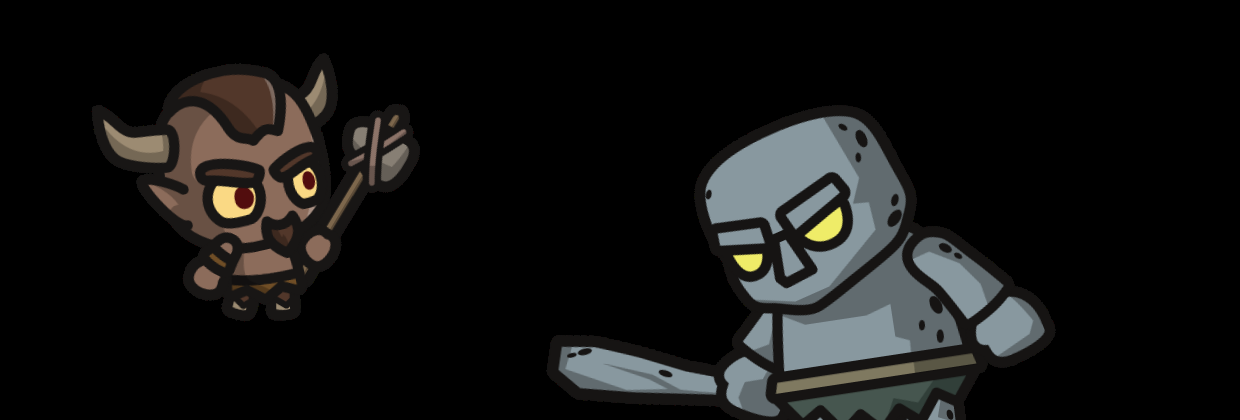

In [29]:
Duel1.draw_scene()

In [28]:
model()

In [8]:
evidence = GameCharacter.evidence([Satyr1.observe("strength", "High"), Golem2.observe("attack", "Low")])

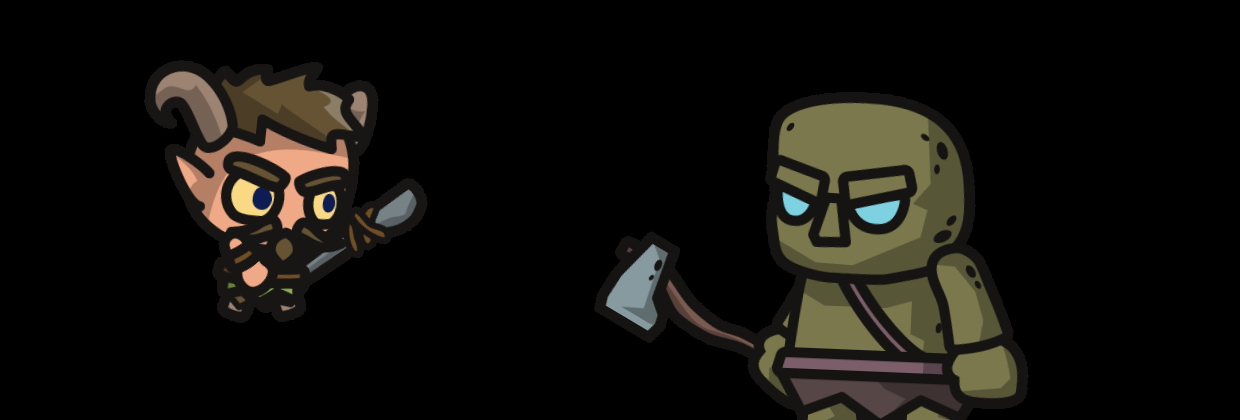

In [9]:
GameCharacter.draw_scene(model, evidence, Duel1)

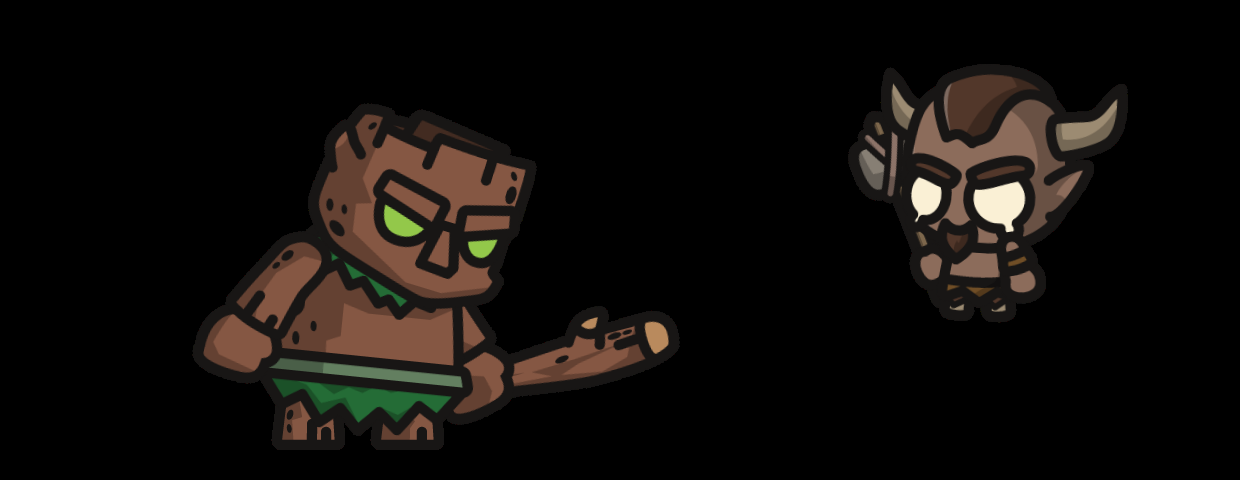

In [14]:
evidence2 = GameCharacter.evidence([Satyr1.observe("strength", "Low"),
                                    Satyr1.observe("attack", "Low"),
                                    Satyr1.observe("defense", "Low"),
                                    Golem2.observe("attack", "High"),
                                   Golem2.observe("defense", "High"),
                                   Golem2.observe("strength", "High")])
GameCharacter.draw_scene(model, evidence2, Duel2)

In [10]:
# Duel1 action when Satyr 1 strength is observed to be Low, what is the probability of his action being attack
GameCharacter.condition(model, evidence, Duel1.infer("action"), 1)

0.298

In [ ]:
# Golem Attacking Defense Strength
# Satyr Attacking Defense Strength

In [ ]:
def gumbel(probs, categories):
    
    return np.argmax()